# Predicting survival based on passenger data

The goal is to take passenger data such as ticket class, gender, etc. and predict whether or not the passenger survives

### Load data

We use a converter because we want to make Sex a numeric variable so that we can use it in future computations. Furthermore, we have to one-hot-encode the Embarked data so that it is numerical. We shouldn't use integer labels because this implies a linear relationship between the locations, which doesn't make sense.

Additionally, we are going to drop the Name, Cabin, and Ticket predictors because we don't expect them to help with prediction and they're more difficult to make numerical.

In [51]:
import pandas as pd
training_data = pd.read_csv('train.csv', index_col='PassengerId', 
                            converters={'Sex': lambda x: 1 if x=='male' else 2}).drop(['Name', 'Ticket', 'Cabin'], axis=1).fillna(0)
testing_data = pd.read_csv('test.csv', index_col='PassengerId', 
                            converters={'Sex': lambda x: 1 if x=='male' else 2}).drop(['Name', 'Ticket', 'Cabin'], axis=1).fillna(0)

training_data = pd.get_dummies(training_data,prefix=['Embarked'], drop_first=True)
testing_data = pd.get_dummies(testing_data,prefix=['Embarked'])



In [52]:
print(training_data.loc[[1,2,3,4,5,6,7,8]])

             Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  \
PassengerId                                                                   
1                   0       3    1  22.0      1      0   7.2500           0   
2                   1       1    2  38.0      1      0  71.2833           1   
3                   1       3    2  26.0      0      0   7.9250           0   
4                   1       1    2  35.0      1      0  53.1000           0   
5                   0       3    1  35.0      0      0   8.0500           0   
6                   0       3    1   0.0      0      0   8.4583           0   
7                   0       1    1  54.0      0      0  51.8625           0   
8                   0       3    1   2.0      3      1  21.0750           0   

             Embarked_Q  Embarked_S  
PassengerId                          
1                     0           1  
2                     0           0  
3                     0           1  
4                  

### Parse data

We want to split the data into predictors and the class (think 'x' and 'y'). 

In [53]:
training_data_x = training_data.drop(['Survived'], axis=1)
training_data_y = training_data['Survived']

## Linear regression

Since we don't necessarily know where to start, let's start with the simplest approach. We'll try lasso and ridge linear regression.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn import linear_model

#Set up Lasso and Ridge Regression models
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

We don't know how much to regularize, so let's try several values (linear regression is cheap and fast).

In [55]:
#Chooose a variety of different lambdas for regularization strength, to compare
lambdas = np.logspace(-3, 3, 10)

Perform the regression

In [56]:
#Initialize coeffficients for ridge regression and Lasso
coefs_ridge = []
coefs_lasso=[]

train_errors_lasso = list()

train_errors_ridge = list()

# Regress!
for a in lambdas:
    ridge.set_params(alpha=a) # ridge() uses alpha instead of labmda to label the regularization penalty strength
    ridge.fit(training_data_x, training_data_y)
    coefs_ridge.append(ridge.coef_)
    
    # Use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(training_data_x, training_data_y))
    
    lasso.set_params(alpha=a)# lasso() uses alpha instead of labmda to label the regularization penalty strength
    lasso.fit(training_data_x, training_data_y)
    coefs_lasso.append(lasso.coef_)
    train_errors_lasso.append(lasso.score(training_data_x, training_data_y))

Plot the size of the model (ie. size of coefficients) as a function of the choice of lambda. A smaller model is better, but the size will collapse as regression overpowers fitting. We want to choose lambda

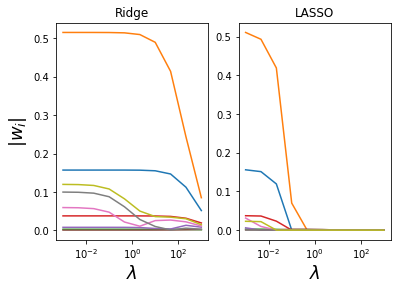

In [57]:
# Display results

# First see how the 10 features we learned scale as we change the regularization parameter
plt.subplot(1,2,1)
plt.semilogx(lambdas, np.abs(coefs_ridge))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('$|w_i|$',fontsize=18)
plt.title('Ridge')
#plt.savefig("Ridge_sparsity_scale.pdf.pdf")



plt.subplot(1,2,2)
plt.semilogx(lambdas, np.abs(coefs_lasso))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
#plt.ylabel('$|\mathbf{w}|$',fontsize=18)
plt.title('LASSO')
#plt.savefig("LASSO_sparsity_scale.pdf")
plt.show()

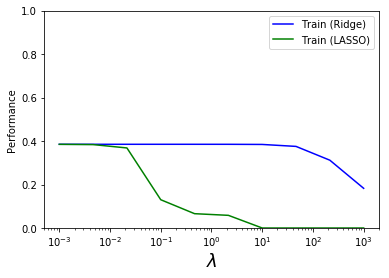

In [58]:
# Plot our performance on the training data
plt.semilogx(lambdas, train_errors_ridge, 'b',label='Train (Ridge)')
plt.semilogx(lambdas, train_errors_lasso, 'g',label='Train (LASSO)')
#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='upper right')
plt.ylim([0, 1.0])
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('Performance')
#plt.savefig("Ridge_LASSO_sparsity_performance.pdf")
plt.show()

We'll choose labmda = 100 for ridge regression and lambda = 0.02 for lasso regression.

In [59]:
lambda_ridge = 100
lambda_lasso = 0.02

## Predictions on test data

Now we want to use our model to make predictions on the test data. Let's see how each model does.

In [60]:
# Make model
ridge.set_params(alpha=lambda_ridge) # ridge() uses alpha instead of labmda to label the regularization penalty strength
ridge.fit(training_data_x, training_data_y)

lasso.set_params(alpha=lambda_lasso)# lasso() uses alpha instead of labmda to label the regularization penalty strength
lasso.fit(training_data_x, training_data_y)

# Make predictions
ridge_predictions = pd.DataFrame(data=(ridge.predict(testing_data) > 0.5).astype(int),
                                 index=testing_data.index, columns=['Survived'])

lasso_predictions = pd.DataFrame(data=(lasso.predict(testing_data) > 0.5).astype(int),
                                 index=testing_data.index, columns=['Survived'])

# Write to file for submission
ridge_predictions.to_csv('ridge_submission.csv')
lasso_predictions.to_csv('lasso_submission.csv')
